# Abstract
With this dataset, I intend to find the relationship between macro/micro nutrients and calories in food. I will use this information to build a model that can predict the calories in a food based on nutritional information.

## Dataset Overview
- **Data Source**: [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
- **Number of Records**: 7,413

In [24]:
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vraosharma-northeastern/exploratory-data-analysis/main/Nutrition%20/food.csv

zsh:1: command not found: wget


In [25]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import shapiro
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Dataset Drilldown & Cleanup

In [26]:
#Reading the file into a dataframe and viewing the first few rows
df = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in df.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    df.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
df.head()

,Category,Description,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

The consistency of the data also presents a challenge. For example, the *Category* column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I am not sure if this is intentional or not, but I will leave this data as is for now. To clean this up, I could use GPT to classify the foods into categories, but that is outside the scope of this project.

**What are the data types?**: Below, we can see the data types in this dataset are object (string), float64, and int64.

In [27]:
# Show data types and count of attributes per that type
df.dtypes.value_counts()

float64    25
int64      19
object      4
dtype: int64

**Are there missing values?**: As we can see below, there are only null values in the two 'Household Weight Description' columns.

In [28]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Household Weights.2nd Household Weight Description    41.818427
Household Weights.1st Household Weight Description     6.340213
Category                                               0.000000
Description                                            0.000000
Fat.Polysaturated Fat                                  0.000000
Fat.Saturated Fat                                      0.000000
Fat.Total Lipid                                        0.000000
Household Weights.1st Household Weight                 0.000000
Household Weights.2nd Household Weight                 0.000000
Major Minerals.Calcium                                 0.000000
Major Minerals.Copper                                  0.000000
Major Minerals.Iron                                    0.000000
Major Minerals.Magnesium                               0.000000
Major Minerals.Phosphorus                              0.000000
Major Minerals.Potassium                               0.000000
Major Minerals.Sodium                   

Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

In [29]:
# Drop 'Household Weight Description' columns
df.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight'], axis=1, inplace=True)

Despite having only non-null values, both categorical and numeric attributes of this dataset have a few "placeholder" values. Let's quantify these.


In [30]:
# Find the number of values in the 'Category' column that ci match '%no category%'
df[df['Category'].str.contains('no category', case=False)]['Category'].count()/ len(df)

0.026709834075273168

We can see that the *Category* column has less than 3% of its values labeled 'no category'. This is not a significant amount of data. Though patterns found using these records would not be all that actionable, we are trying to understand the relationship between nutrients and calories, so we will keep these records in the dataset. Later, we can remove these records and see if our model improves.

Let's now target the numeric columns. We will look for values that are 0, which are likely placeholders for missing data.

In [31]:
# Show the percentage of 0s in each numeric column of the dataset. In another table, show the percentage of 1s in each numeric column of the dataset.

df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x[x == 0].count() / len(df)).sort_values(ascending=False)

Lycopene                                  0.966275
Beta Cryptoxanthin                        0.920005
Alpha Carotene                            0.918117
Refuse Percentage                         0.804667
Lutein and Zeaxanthin                     0.788075
Beta Carotene                             0.739512
Retinol                                   0.716444
Vitamins.Vitamin K                        0.571024
Choline                                   0.547552
Vitamins.Vitamin A - RAE                  0.508701
Vitamins.Vitamin C                        0.505733
Vitamins.Vitamin B12                      0.499933
Sugar Total                               0.482800
Cholesterol                               0.476190
Fiber                                     0.461082
Vitamins.Vitamin E                        0.458249
Vitamins.Vitamin A - IU                   0.362067
Manganese                                 0.244975
Selenium                                  0.242277
Pantothenic Acid               

Because we're dealing with a variety of foods, it makes sense that certain nutrients would be absent, so we will not impute any of these values. However, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0. Knowing the weight of two similar foods is crucial to understand relative nutritional value.

In [32]:
# Drop rows where Household Weights.1st Household Weight is 0
df = df[df['Household Weights.1st Household Weight'] != 0]

Next, let's limit the scope of our dataset to exclude information that gives is found in small quantities in food. We will remove the following columns to simplify our analysis because we don't care about their correlation to KCAL:
1. **Alpha Carotene**
2. **Beta Carotene**
3. **Beta Cryptoxanthin**
4. **Lycopene**
5. **Lutein and Zeaxanthin**
6. **Retinol**
7. **Riboflavin**
8. **Selinium**
9. **Thiamin**
10. **Choline**
11. **Manganese**
12. **Niacin**
13. **Pantothenic Acid**
14. **Refuse Percentage**

In [33]:
# Drop columns that are not relevant to our analysis
df.drop(['Alpha Carotene', 'Beta Carotene', 'Beta Cryptoxanthin', 'Lycopene', 'Lutein and Zeaxanthin', 'Retinol', 'Riboflavin', 'Selenium', 'Thiamin', 'Choline', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Refuse Percentage'], axis=1, inplace=True)

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [34]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
df.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
0 Ash: g
1 Carbohydrate: g
3 Cholesterol: mg
5 Fat.Monosaturated Fat: g
6 Fat.Polysaturated Fat: g
7 Fat.Saturated Fat: g
8 Fat.Total Lipid: g
9 Fiber: g
10 Household Weights.1st Household Weight: g
12 Kilocalories: kcal
13 Major Minerals.Calcium: mg
14 Major Minerals.Copper: mg
15 Major Minerals.Iron: mg
16 Major Minerals.Magnesium: mg
17 Major Minerals.Phosphorus: mg
18 Major Minerals.Potassium: mg
19 Major Minerals.Sodium: mg
20 Major Minerals.Zinc: mg
22 Protein: g
24 Sugar Total: g
26 Vitamins.Vitamin A - RAE: µg
27 Vitamins.Vitamin B12: µg
28 Vitamins.Vitamin B6: µg
29 Vitamins.Vitamin C: µg
30 Vitamins.Vitamin E: mg
31 Vitamins.Vitamin K: µg
32 Water: g

In [35]:
# Show the first row of the dataset in alphabetical order
df.sort_index(axis=1).head(1)

,Ash,Carbohydrate,Category,Cholesterol,Description,Fat.Monosaturated Fat,Fat.Polysaturated Fat,Fat.Saturated Fat,Fat.Total Lipid,Fiber,...,Nutrient Data Bank Number,Protein,Sugar Total,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K,Water
0,2.11,0.06,BUTTER,215,"BUTTER,WITH SALT",21.021,3.043,51.368,81.11,0.0,...,1001,0.85,0.06,684,0.17,0.003,0.0,2.32,7.0,15.87


We can

 **Which independent variables have missing data? How much?**: Now that we've cleaned the dataset of irrelevant data, let's look at the missing values again. We can see below that there are no missing values. Remember, we have those  'no category' records in the *Category* column (3%), but we will keep those for now.

In [36]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Category                                              0.0
Household Weights.1st Household Weight Description    0.0
Vitamins.Vitamin E                                    0.0
Vitamins.Vitamin C                                    0.0
Vitamins.Vitamin B6                                   0.0
Vitamins.Vitamin B12                                  0.0
Vitamins.Vitamin A - RAE                              0.0
Major Minerals.Zinc                                   0.0
Major Minerals.Sodium                                 0.0
Major Minerals.Potassium                              0.0
Major Minerals.Phosphorus                             0.0
Major Minerals.Magnesium                              0.0
Major Minerals.Iron                                   0.0
Major Minerals.Copper                                 0.0
Major Minerals.Calcium                                0.0
Household Weights.1st Household Weight                0.0
Description                                           0.0
Fat.Total Lipi

**What are the likely distributions of the numeric variables?**: Now that we've cleaned up the dataset, let's see the distributions of the numeric variables. We will use a histogram to visualize the distributions of the numeric variables.

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


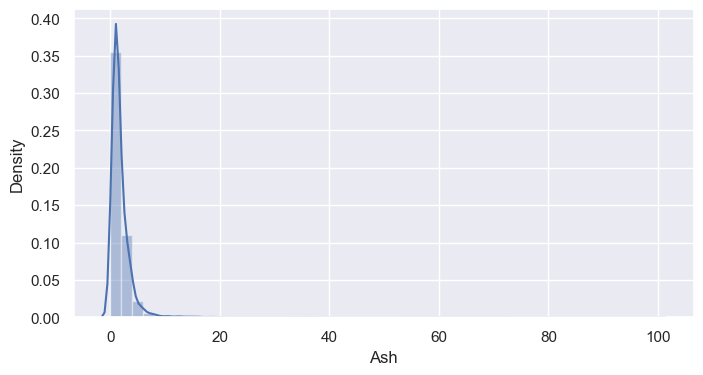

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


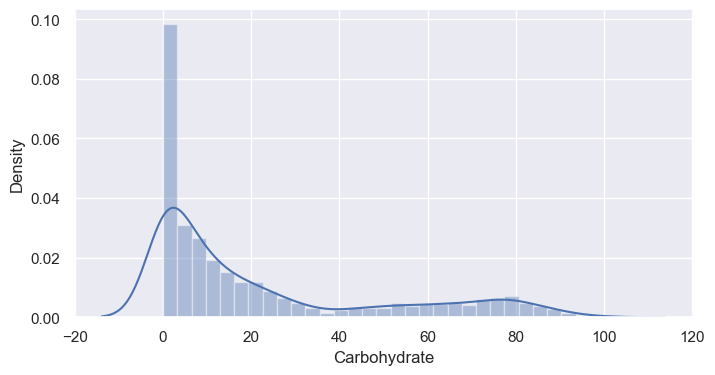

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


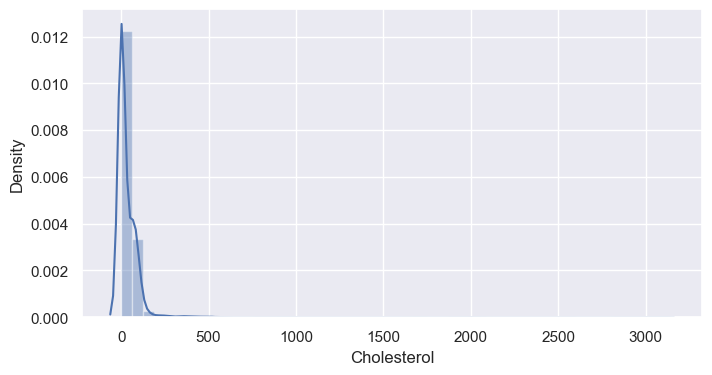

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


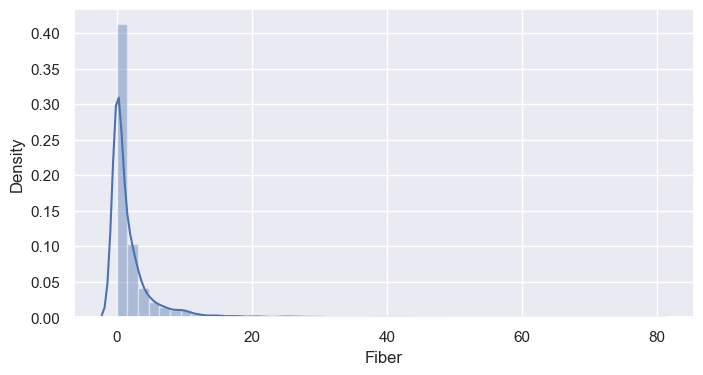

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


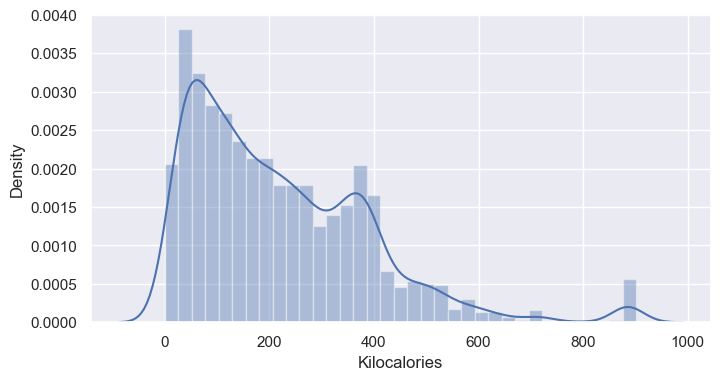

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


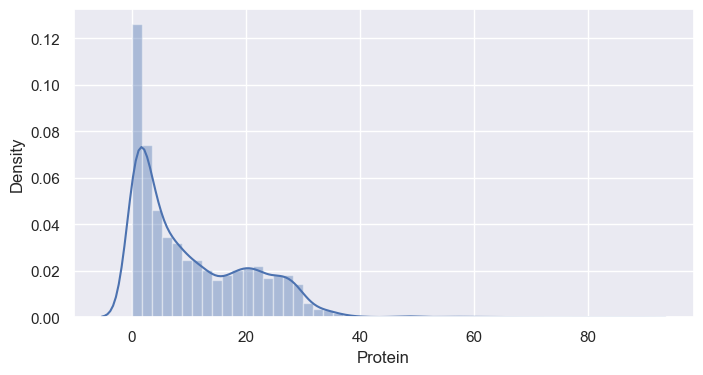

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


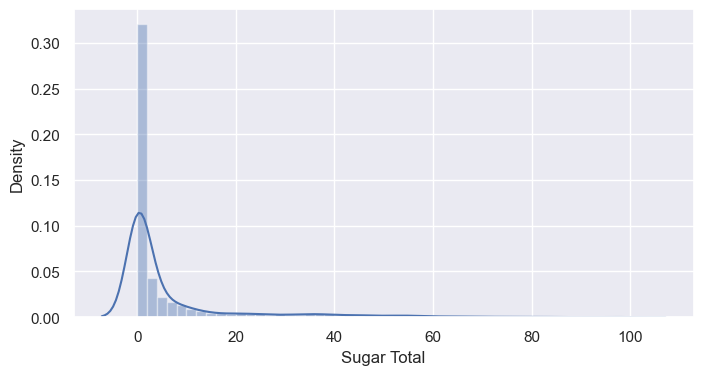

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


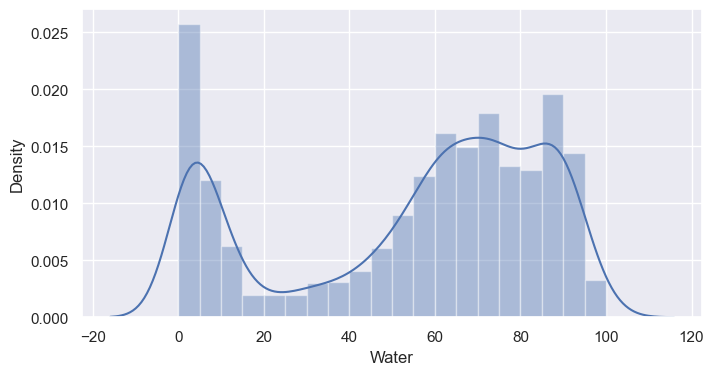

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


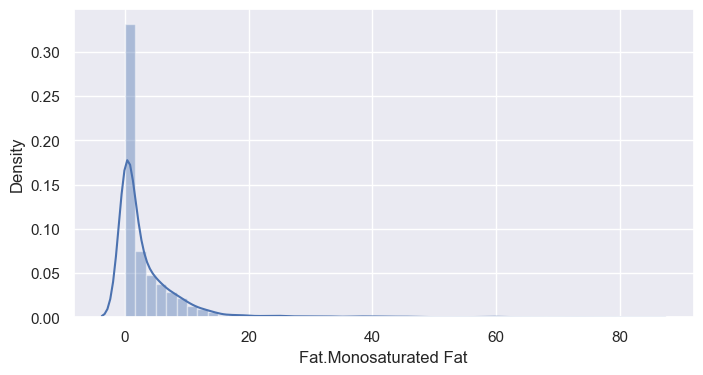

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


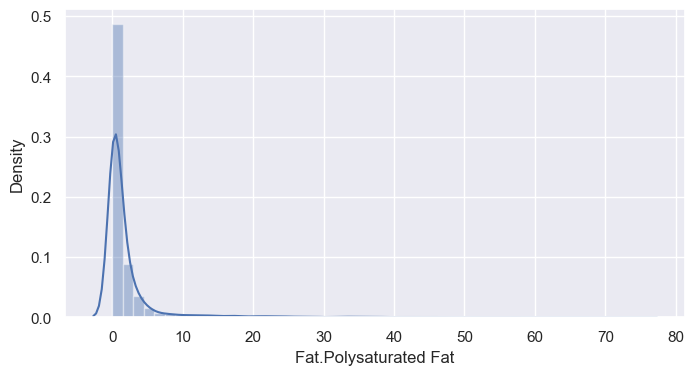

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


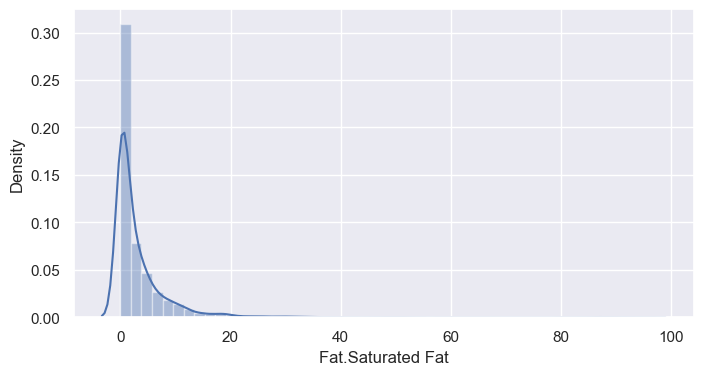

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


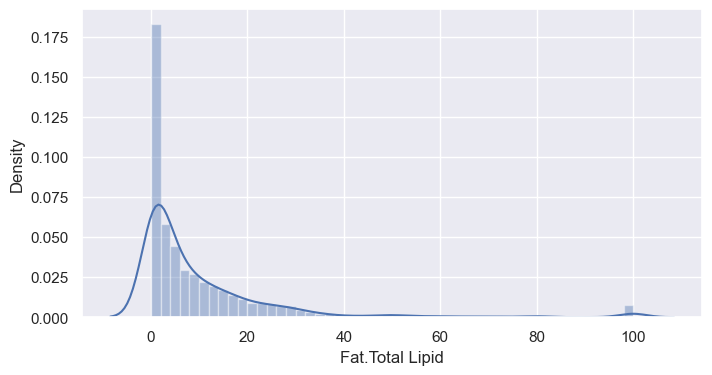

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


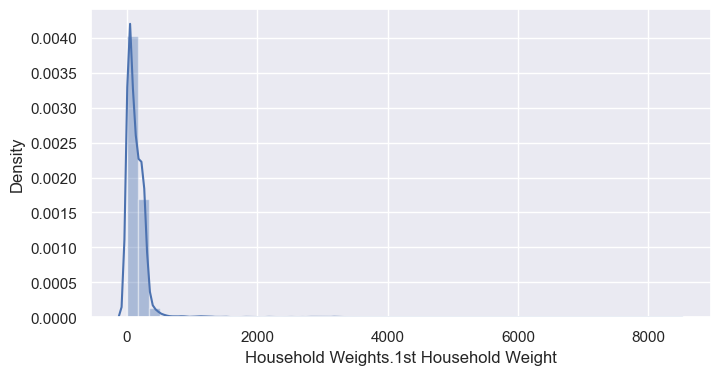

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


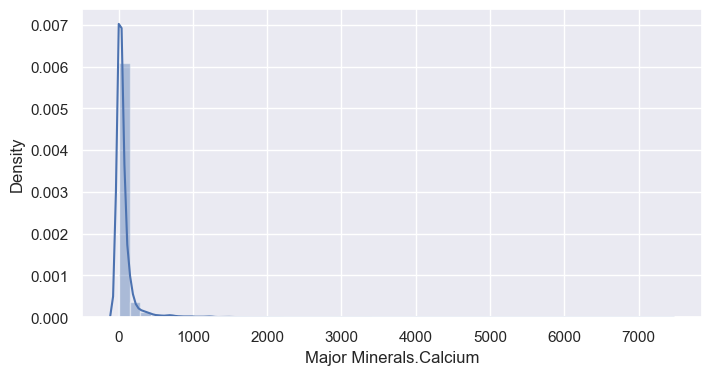

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


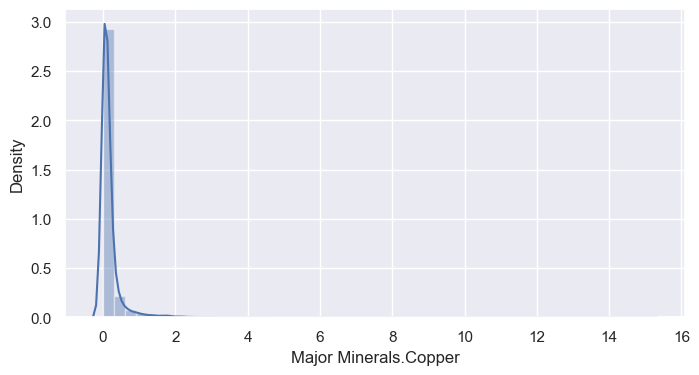

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


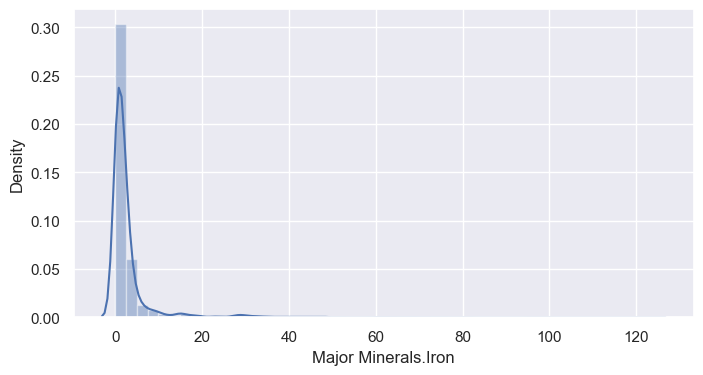

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


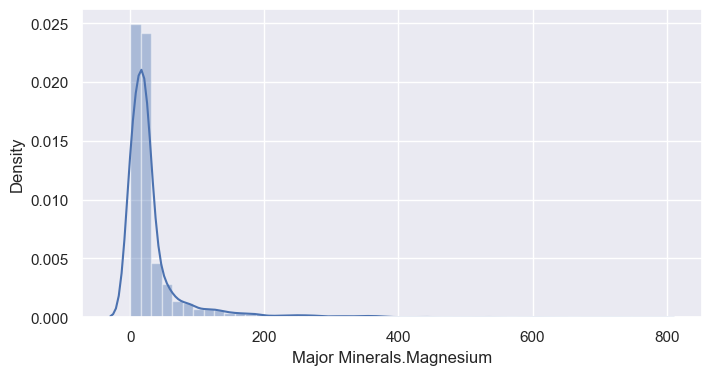

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


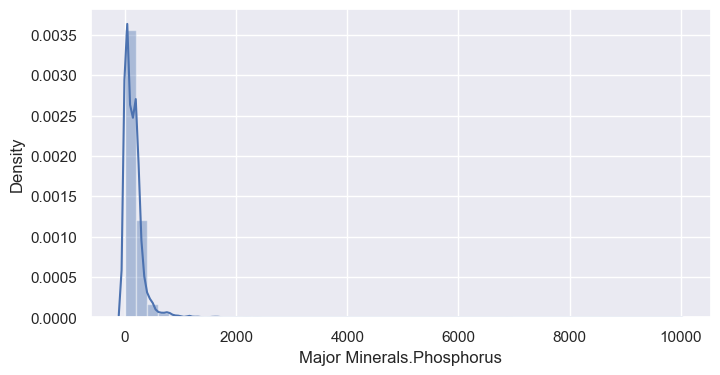

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


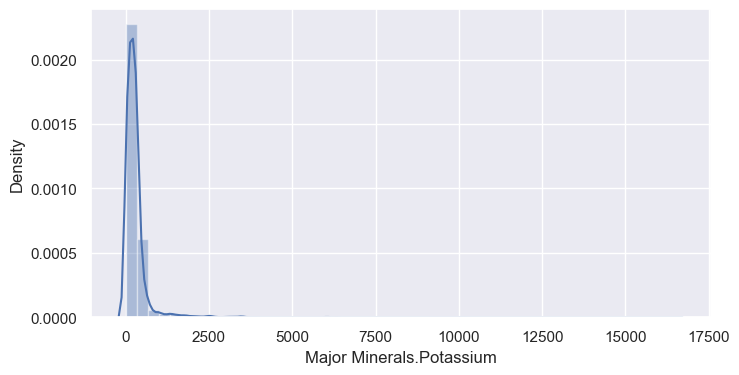

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


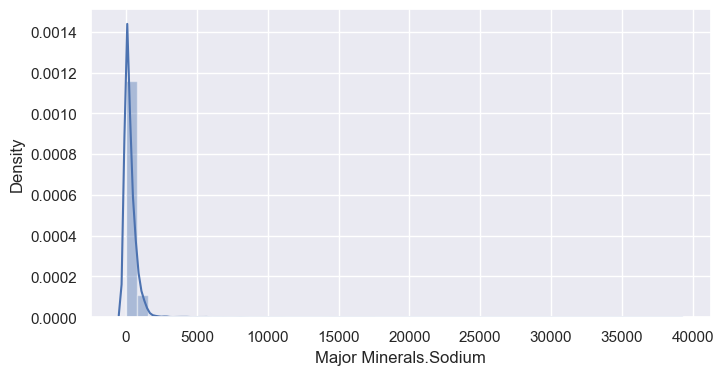

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


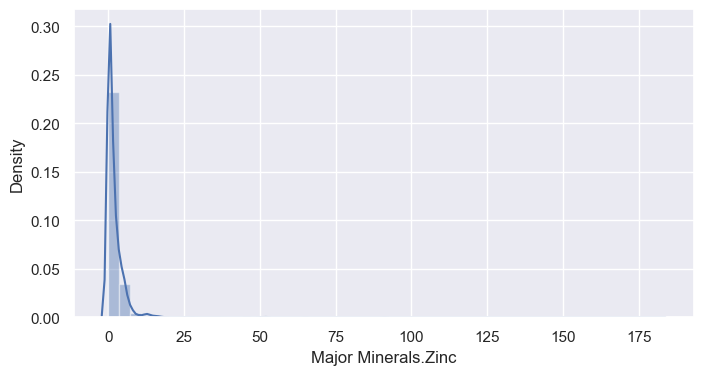

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


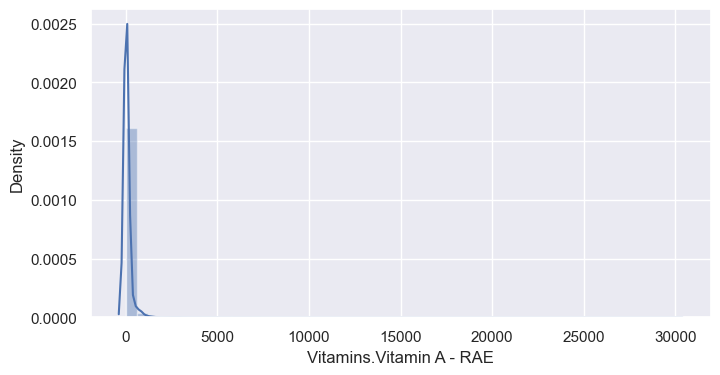

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


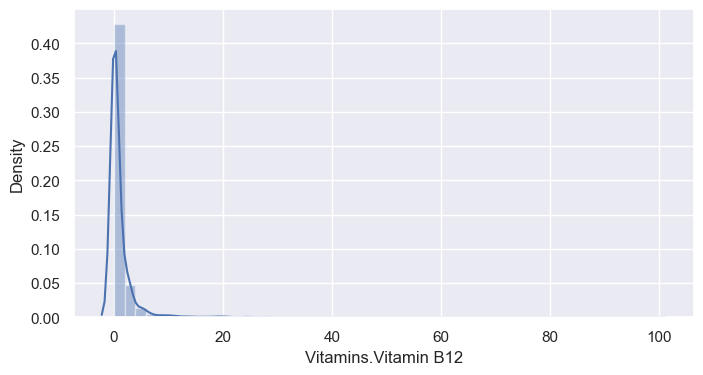

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


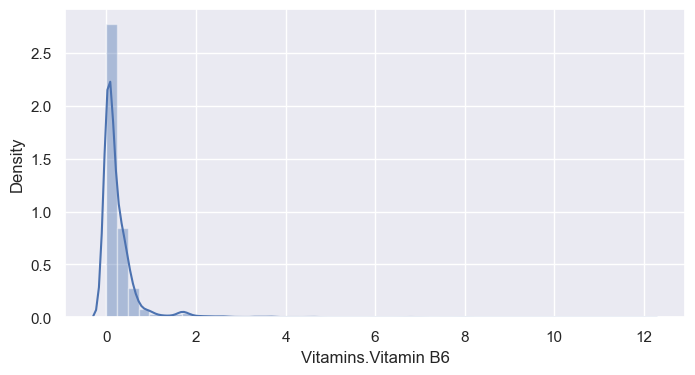

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


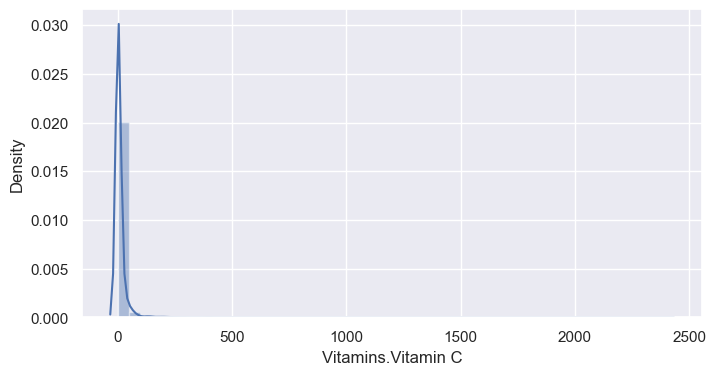

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


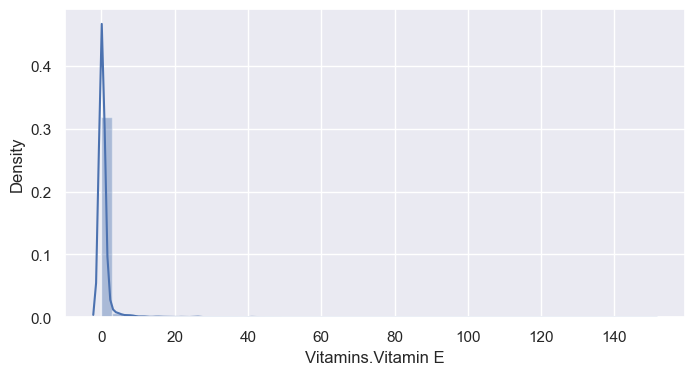

/var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/ipykernel_57687/845091844.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


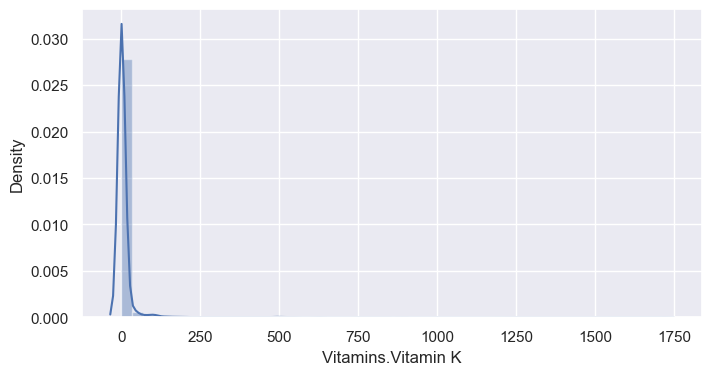

In [37]:
# Add the numeric columns excluding Nutrient Data Bank Number to a list
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

#create a histogram for each numeric column
for column in numeric_cols.columns:
    sns.set(rc={"figure.figsize": (8, 4)});
    sns.distplot(df[column])
    plt.show()



We can see that the distributions of the numeric variables are very right-tailed. This is expected because not all foods have the same nutritional value. For example, some foods are very rich in Vitamin A like Cod Liver, while others have none. In a later step, perhaps we will remove these micronutrients to see if our model performance improves.

The only variable that looks roughly normal is water. Let's perform the Shapiro-Wilk test to verify if Water's or any other of the distributions are normal.

In [38]:
# Perform the Shapiro-Wilk test on each numeric column excluding Nutrient Data Bank Number
for column in numeric_cols.columns:
    stat, p = shapiro(df[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('{} looks Normal (fail to reject H0)'.format(column))
    else:
        print('{} does not look Normal (reject H0)'.format(column))

Statistics=0.338, p=0.000
Ash does not look Normal (reject H0)
Statistics=0.779, p=0.000
Carbohydrate does not look Normal (reject H0)
Statistics=0.234, p=0.000
Cholesterol does not look Normal (reject H0)
Statistics=0.487, p=0.000
Fiber does not look Normal (reject H0)
Statistics=0.899, p=0.000
Kilocalories does not look Normal (reject H0)
Statistics=0.867, p=0.000
Protein does not look Normal (reject H0)
Statistics=0.533, p=0.000
Sugar Total does not look Normal (reject H0)
Statistics=0.881, p=0.000
Water does not look Normal (reject H0)
Statistics=0.530, p=0.000
Fat.Monosaturated Fat does not look Normal (reject H0)
Statistics=0.367, p=0.000
Fat.Polysaturated Fat does not look Normal (reject H0)
Statistics=0.472, p=0.000
Fat.Saturated Fat does not look Normal (reject H0)
Statistics=0.609, p=0.000
Fat.Total Lipid does not look Normal (reject H0)
Statistics=0.359, p=0.000
Household Weights.1st Household Weight does not look Normal (reject H0)
Statistics=0.281, p=0.000
Major Minerals.C

/Users/vraosharma/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we can see above, none of the distributions are normal. This is expected because the distributions are right-tailed. We will not transform the data to make it normal because we are not using any models that require normality.

**Note to Reader** - I am not sure if the Shapiro-Wilk test is the perfect test to use here. Also, I attempted to show QQ plots for this data to interpret if the distributions were another common distribution, but I was not able to tell. I would appreciate any feedback on this.

 **Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)**
For our target variable, we will use *Kilocalories* because it is a measure of energy and is a good indicator of the nutritional value of a food. Below we will use a few methods to determine which independent variables are useful to predict *Kilocalories*

<Axes: >

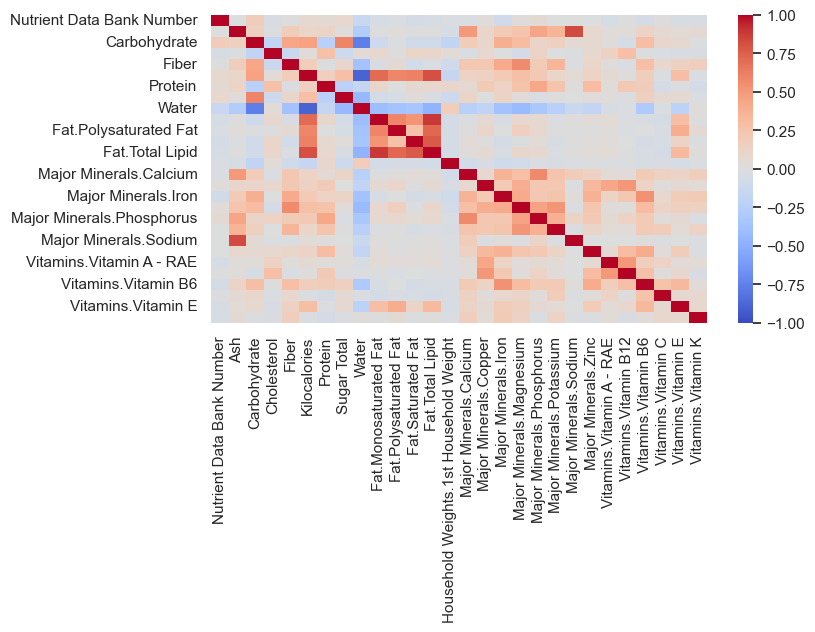

In [42]:
# Create a correlation matrix of the numeric columns
corr = df.select_dtypes(include=['float64', 'int64']).corr()

# Plot the correlation matrix to a heatmap
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)


A few things jump out at us from the heatmap that will help us narrow down our features:
1.  *Fat.Total Lipid* and the other sub-types of fat (e.g. *Monounsaturated*, *Saturated*) are highly correlated to each other. This makes sense because Total Lipid is the sum of the other sub-types of fat. Because we are trying to predict *Kilocalories* and it has the strongest correlation to it, we will keep *Fat.Total Lipid* and drop the other sub-types of fat.
2.

## References

1. [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
2. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb
3.https://fdc.nal.usda.gov/index.html
3. https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE

## Acknowledgements

I would like to thank [Shruti Saxena](https://www.kaggle.com/shrutisaxena) for sharing this dataset on Kaggle.
